In [1]:
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from models.data import CURVASDataModule
from models.mae.mae import ViTAE
from models.encoders import DinoViT_16, DinoViT_8, Dinov2ViT_14, ResNet34_8x8, get_resnet34_encoder
from models.segmentation import ObjectSpecificSegmentation

from pytorch_lightning.loggers import WandbLogger
from pathlib import Path

from torch_uncertainty.metrics import AURC, AUSE
from torch_uncertainty.metrics.classification import CalibrationError
from monai.networks import one_hot
from torch_uncertainty.transforms.corruptions import (
    GaussianNoise,
    SpeckleNoise,
)

from models.uncertainty_measures import 

: 

In [2]:
def image_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def ground_truth_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['labelmap'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def uncertainty_metrics(oss, batch, trials=500, transform='GaussianNoise'):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    aurc_metric = AURC()
    ece_metric = CalibrationError('multiclass', num_bins=20, num_classes=4, norm='l1')

    batch = {k: v.to('cuda') for k, v in batch.items()}
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])
            _, _, probs, preds, _, _, _, _ = oss.process_batch(batch, 1)
            targets = batch['labelmap'][:, 0].unsqueeze(1)     #one_hot(batch['ground_truth'], num_classes=4)
            # flatten probs and targets
            probs = probs.squeeze(2).permute(0, 2, 3, 1)
            probs = probs.reshape(-1, probs.shape[-1]).to('cpu')
            targets = targets.permute(0, 2, 3, 1)
            targets = targets.reshape(-1).to('cpu')  # Changed this line
            
            # flatten preds
            preds = preds.reshape(-1).to('cpu')  # Added this line
            
            # remove targets and probs where target is background class (0) and is correctly predicted
            # mask = ~((preds == 0) & (targets == 0))  
            # probs = probs[mask]
            # targets = targets[mask]
            
            # Convert targets to one-hot encoding
            targets = one_hot(targets.unsqueeze(1), num_classes=4).argmax(dim=1)
            
            aurc_metric.update(probs, targets)
            ece_metric.update(probs, targets)

    return ece_metric, aurc_metric

def get_samples(model, batch, trials=500, transform=None):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    model.probabilistic_sample = True
    model.to('cuda')
    batch = {k: v.to('cuda') for k, v in batch.items()}
    list_entropy = []
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])

            _, _, _, preds, _, _, _, _ = model.process_batch(batch, 1)

            list_entropy.append(preds)

    all_preds = torch.stack(list_entropy, dim=1)

    return all_preds.float()

: 

In [3]:
encoder = DinoViT_16()

oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/abd_seg/abd_seg/1_ar_t/checkpoints/epoch=429-step=119110.ckpt',
                                encoder=encoder, strict = False)

Using cache found in /homes/bc1623/.cache/torch/hub/facebookresearch_dino_main
/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [4]:
data = CURVASDataModule(batch_size=32, cache=True, augmentation=False,
                            random_seed=42)

Dataset size (4.5 GiB) fits in cache limit (20 GiB). Allocating space to cache all 1150 samples.


Loading Data: 100%|██████████| 1/1 [00:17<00:00, 17.87s/it]


Dataset size (4.5 GiB) fits in cache limit (20 GiB). Allocating space to cache all 1150 samples.


Loading Data: 100%|██████████| 1/1 [00:18<00:00, 18.61s/it]


Dataset size (9.0 GiB) fits in cache limit (20 GiB). Allocating space to cache all 2300 samples.


Loading Data: 100%|██████████| 2/2 [00:37<00:00, 18.51s/it]


: 

In [27]:
trainer = Trainer(precision=16, accelerator='auto', callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)])
oss.slot_attention.probabilistic_sample = False
trainer.test(oss, dataloaders=data.test_dataloader())


/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/pytorch_lightning/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/vol/bit

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.8907948136329651     │
│         test_loss         │    0.23597639799118042    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.23597639799118042, 'test_dice': 0.8907948136329651}]

In [30]:
torch.std(torch.Tensor([0.89079, 0.88751, 0.85211]))

tensor(0.0214)

In [6]:
# from pytorch_lightning.loggers import WandbLogger
# from pathlib import Path
# wandb_logger = WandbLogger(save_dir='./runs/lightning_logs/synthetic_cardiac/', project='synthetic_cardiac',
#                            name='add_t_unsup_finetune_4', id='add_t_unsup_finetune_4', offline=False)
# output_dir = Path(f"synthetic_cardiac/run_{wandb_logger.experiment.id}")  # type: ignore
# print("Saving to" + str(output_dir.absolute()))

# trainer = Trainer(
#     max_epochs=10000,
#     #precision='16-mixed',
#     accelerator='auto',
#     devices=[0],
#     #strategy='ddp_notebook',
#     # log_every_n_steps=250,
#     #val_check_interval=0.25,
#     check_val_every_n_epoch=25,
#     limit_train_batches=2,
#     # #save_top_k=1,
#     logger=wandb_logger,
#     callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)],
# )
# torch.set_float32_matmul_precision('medium')

# trainer.fit(model=oss, datamodule=data)

# trainer.validate(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# trainer.test(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Text(0.5, 1.0, 'Prediction')

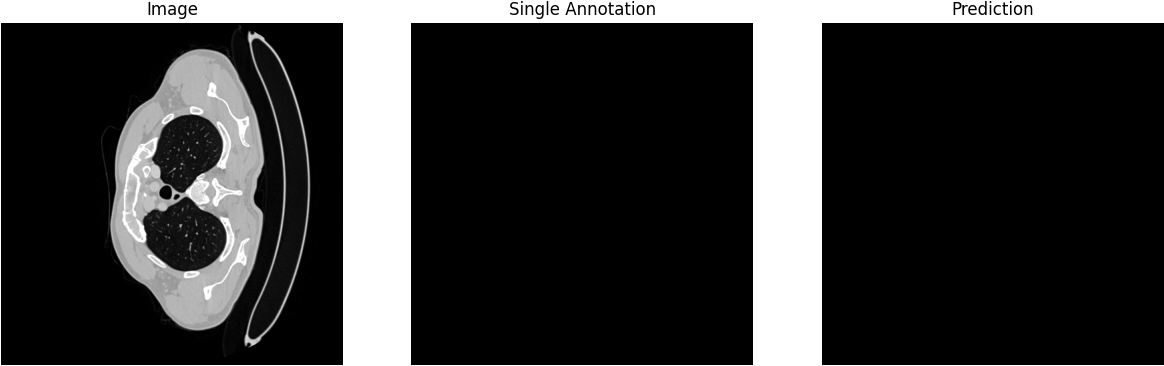

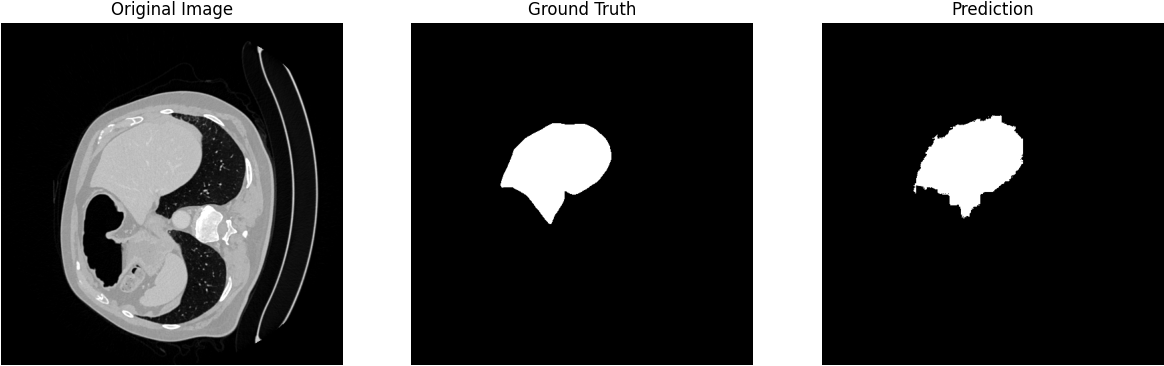

In [9]:
oss.slot_attention.probabilistic_sample = False
image_num = 1
batch = next(iter(data.test_dataloader()))
cuda_device = torch.device('cuda:0')
oss.num_iterations = 3
# batch['image'] = batch['image'][:2]

# batch['labelmap'] = batch['labelmap'][:2]
# batch['ground_truth'] = batch['ground_truth'][:2]
# move to gpu
batch = {k: v.to(cuda_device) for k, v in batch.items()}
oss.to(cuda_device)

with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['labelmap'][image_num].squeeze().cpu()
# probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Image')

ax[1].imshow(labelmap[0], cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Single Annotation')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Prediction')

# ax[3].imshow(probmap[image_num, ...], cmap='plasma')
# ax[3].axis('off')
# ax[3].set_title('probability map')

image_num += 1
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['labelmap'][image_num].squeeze().cpu()
# probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(labelmap[0], cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Prediction')

# ax[3].imshow(probmap[image_num, ...], cmap='plasma')
# ax[3].axis('off')
# ax[3].set_title('probability map')

Text(0.5, 1.0, 'Annotation 3')

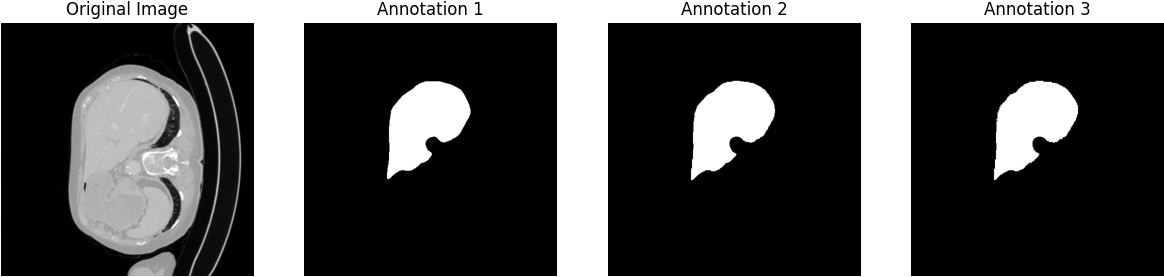

In [40]:
# plot all 3 annotations
image_num = 2
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['labelmap'][image_num].squeeze().cpu()
annotation1, annotation2, annotation3 = torch.split(labelmap, 1, dim=0)

f, ax = plt.subplots(1, 4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(annotation1.squeeze(0), cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Annotation 1')

ax[2].imshow(annotation2.squeeze(0), cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Annotation 2')

ax[3].imshow(annotation3.squeeze(0), cmap=matplotlib.cm.gray)
ax[3].axis('off')
ax[3].set_title('Annotation 3')

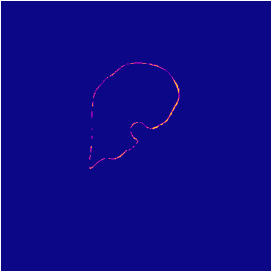

In [41]:
var = torch.var(labelmap.float(), dim=0).squeeze().cpu()
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(var, cmap='plasma')
ax.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'Variance Map')

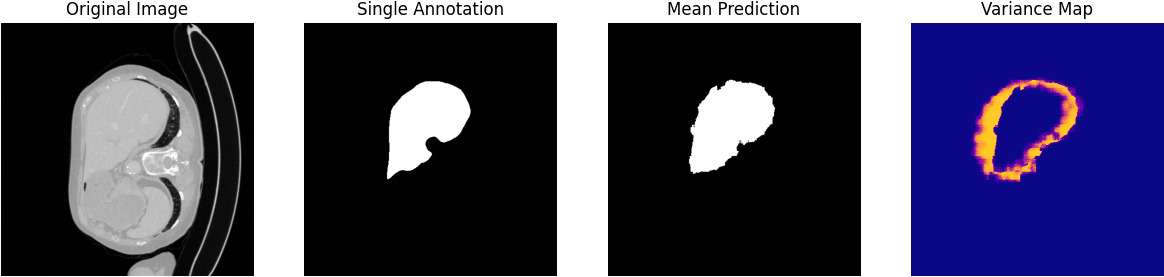

In [42]:
image_num = 2
# data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)
# batch = next(iter(data.test_dataloader()))
cuda_device = torch.device('cuda:0')
# batch = {k: v.to(cuda_device) for k, v in batch.items()}

oss.to(cuda_device)
oss.probabilistic_sample = False
oss.include_seg_loss = False
# noised_batch = batch.copy()
# transform = GaussianNoise(5)
# noised_batch['image'] = noised_batch['image'][:4].to(cuda_device)
batch['image'] = batch['image'][:4].to(cuda_device)
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze().cpu()
# noised_image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['labelmap'][image_num][0].squeeze().cpu()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1, 4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

# ax[1].imshow(noised_image, cmap=matplotlib.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('Noised Image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Single Annotation')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Mean Prediction')

# pixel_entropy = calculate_class_entropy(all_preds[image_num, ...].squeeze()).cpu()
pixel_entropy = torch.std(get_samples(oss, batch), dim=1)[image_num].squeeze().cpu()
ax[3].imshow(pixel_entropy, cmap='plasma')
ax[3].axis('off')
ax[3].set_title('Variance Map')

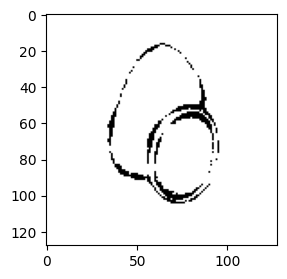

In [7]:
# show ground truth minus mean prediciton
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(labelmap == predmap, cmap='gray')

(-0.5, 127.5, 127.5, -0.5)

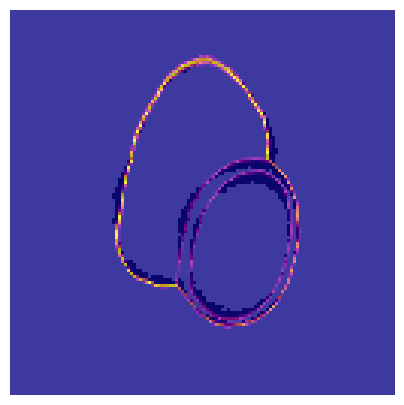

In [12]:
image_num = 0

f, ax = plt.subplots(1, 1, figsize=(5, 5))

# colorbar
# mappable = ax.imshow(pixel_entropy, cmap='plasma')
# f.colorbar(mappable, ax=ax)
ax.imshow(labelmap == predmap, cmap='gray')
ax.imshow(pixel_entropy, cmap='plasma', alpha=0.8)
ax.axis('off')
# ax.set_title('Prediction Entropy')

(-0.5, 127.5, 127.5, -0.5)

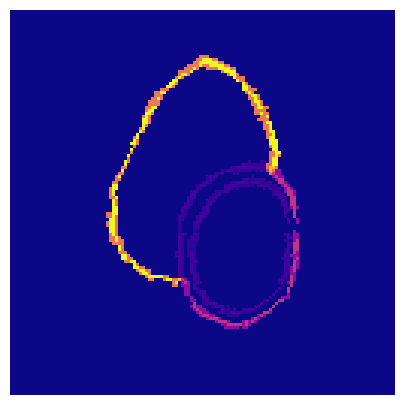

In [77]:
batch = next(iter(data.test_dataloader()))

var = torch.var(batch['labelmap'][image_num].float(), dim=0).squeeze().cpu()
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(var, cmap='plasma')
ax.axis('off')

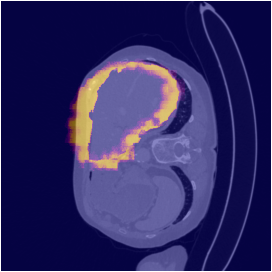

In [43]:
image_num = 2
# batch = next(iter(data.test_dataloader()))
image = batch['image'][image_num].squeeze().cpu()
# image = image.squeeze().cpu()
# batch = next(iter(data.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()

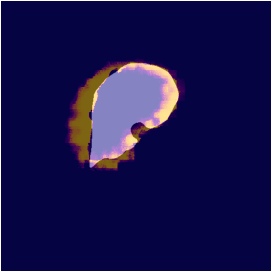

In [44]:
# image_num = 0
# image = image.squeeze().cpu()
# batch = next(iter(data.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['labelmap'][image_num][0].squeeze().cpu(), cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()

In [31]:
# data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=False, random_seed=42)
batch = next(iter(data.test_dataloader()))
batch['image'] = batch['image'].to(cuda_device)
batch['labelmap'] = batch['labelmap'][:, 0].to(cuda_device).unsqueeze(1)
oss.to(cuda_device)
ece_metric, aurc_metric = uncertainty_metrics(oss, batch, trials=500, transform=None)

: 

In [23]:
ece_metric.compute()

tensor(0.0246)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Coverage (%)', ylabel='Risk - Error Rate (%)'>)

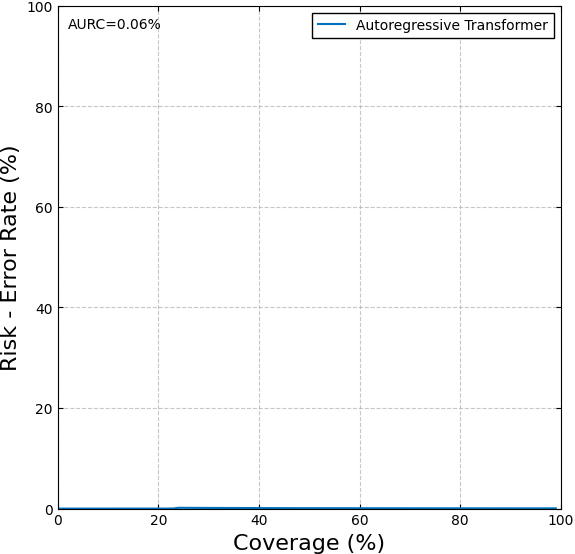

In [24]:
aurc_metric.plot(name='Autoregressive Transformer')

In [25]:
data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)

Loading Data: 100%|██████████| 1000/1000 [00:00<00:00, 727293.91it/s]


In [26]:
batch = next(iter(data.test_dataloader()))
print(len(batch['image']))

25


In [17]:
from torchmetrics.functional import dice
batch = next(iter(data.test_dataloader()))
batch = {k: v.to(cuda_device) for k, v in batch.items()}
gt = batch['ground_truth'].squeeze().to('cuda')
oss.to('cuda')
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
dsc = dice(preds, gt, average='macro', num_classes=4, ignore_index=0)
print(dsc)

tensor(0.8537, device='cuda:0')
